<a href="https://colab.research.google.com/drive/1AGZ0U8dxkPULuJCHX5ixO-OXyRqx4uTn?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [ ]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [ ]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:** c увеличением батча обучение, как кажется, должно идти медленнее, т.к. вычисления будут становиться сложнее

Посмотрим на какую-нибудь картинку:

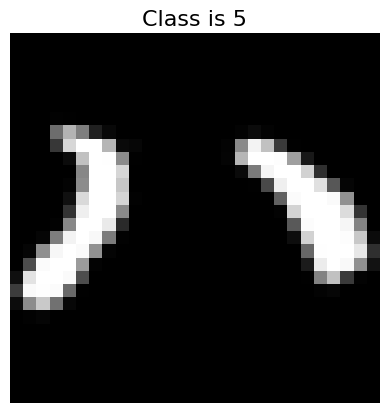

In [ ]:
plt.imshow(trainset[13][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[13][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





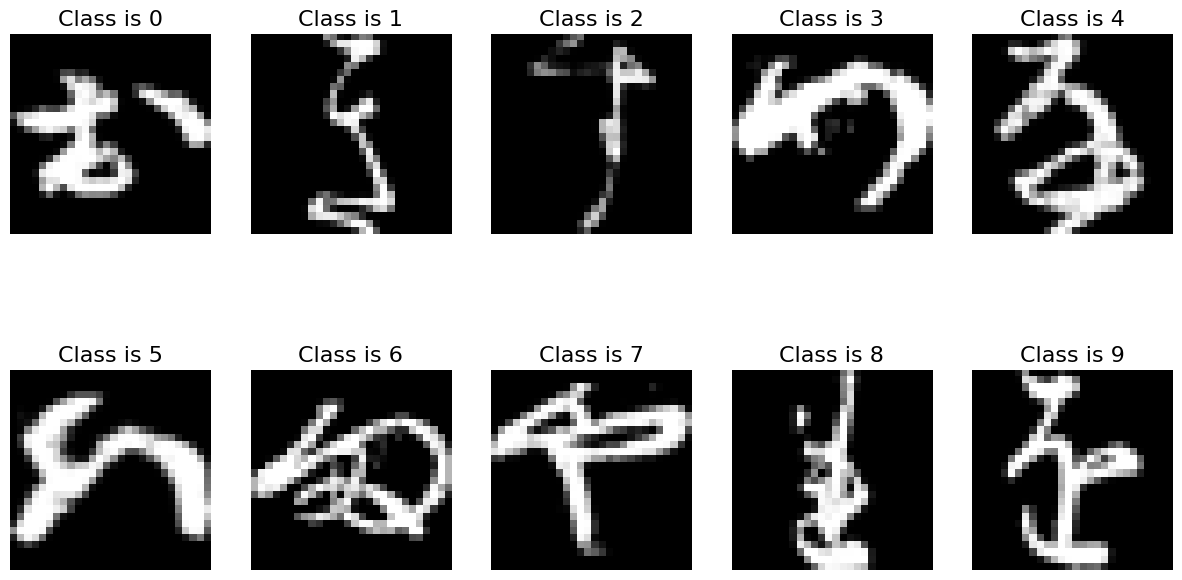

In [ ]:
# Список с 10 случайными картинками разных классов
pics = []
for i in range(10):
    j = -1
    while j != i:
        idx = np.random.choice(range(0,len(trainset)))
        pic = trainset[idx]
        j = pic[1]
    pics.append(pic)
# График
fig, axs = plt.subplots(2,5)
fig.set_size_inches(15, 8)
for i in range(10):
    axs[int(i>4),i-int(i>4)*5].imshow(pics[i][0].view(28, 28).numpy(), cmap="gray")
    axs[int(i>4),i-int(i>4)*5].axis("off")
    axs[int(i>4),i-int(i>4)*5].set_title(f"Class is {pics[i][1]}", fontsize=16);

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [ ]:
from torch.nn.modules.activation import ReLU
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)


    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.fc3(x)
        # функция активации после последнего слоя, как понимаю, - софтмакс, которая будет логиты превращать в вероятность

        return x

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

Каждый нейрон имеет вес для каждого элемента входных данных и одно смещение, значит всего настраиваемых параметров:

In [ ]:
(28*28)*256 + 256 + 256*128 + 128 + 128*10 + 10

235146

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [ ]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [ ]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.SGD(fc_net.parameters(), lr=lr)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [ ]:
%%time
n_epochs = 10
loss_history = []

## YOUR CODE HERE
for epoch in range(n_epochs):
    for images, labels in trainloader:
        optimizer.zero_grad() 
        outputs = fc_net(images) 
        loss = loss_function(outputs, labels)
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска


CPU times: user 22 s, sys: 1.66 s, total: 23.6 s
Wall time: 2min 4s


In [ ]:
get_accuracy(fc_net, testloader)

0.2774

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [ ]:
mean = (sum([i.mean(dim=(1,2)) for i, _ in trainset])/len(trainset)).item()
std = (sum([i.std(dim=(1,2)) for i, _ in trainset])/len(trainset)).item()
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

0.19176195561885834 0.3385268747806549


In [ ]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.SGD(fc_net.parameters(), lr=lr)

In [ ]:
n_epochs = 10
loss_history = []

## YOUR CODE HERE
for epoch in range(n_epochs):
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска




In [ ]:
get_accuracy(fc_net, testloader)

0.4943

Как изменилась `accuracy` после нормализации?

- увеличилась на 



In [ ]:
0.4943 - 0.2774

0.21690000000000004

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [ ]:
## YOUR CODE HERE

#Нервная сеть с сигмоидой
class FCNet_sigmoid(nn.Module):
    def __init__(self):
        super().__init__() 
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)


    def forward(self, x): 

        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = nn.functional.sigmoid(x)
        x = self.fc2(x)
        x = nn.functional.sigmoid(x)
        x = self.fc3(x)

        return x

# с GELU
class FCNet_GELU(nn.Module):
    def __init__(self):
        super().__init__() 
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)


    def forward(self, x): 

        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = nn.functional.gelu(x)
        x = self.fc2(x)
        x = nn.functional.gelu(x)
        x = self.fc3(x)

        return x

# с Tanh
class FCNet_Tanh(nn.Module):
    def __init__(self):
        super().__init__() 
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)


    def forward(self, x): 

        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = nn.functional.tanh(x)
        x = self.fc2(x)
        x = nn.functional.tanh(x)
        x = self.fc3(x)

        return x

Прошу простить за такой формат: хотел сделать в цикле, в одной ячейке, но не получилось померить время с помощью `time.time()`или `%time`, поэтому сделал разные запуски в разных ячейках.

In [ ]:
# Sigmoid
%%time
fc_net = FCNet_sigmoid()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.SGD(fc_net.parameters(), lr=lr)

n_epochs = 10
for epoch in range(n_epochs):
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска


get_accuracy(fc_net, testloader)

CPU times: user 22.7 s, sys: 1.85 s, total: 24.5 s
Wall time: 2min 42s


0.2731

In [ ]:
# GELU
%%time
fc_net = FCNet_GELU()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.SGD(fc_net.parameters(), lr=lr)

n_epochs = 10
for epoch in range(n_epochs):
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска


get_accuracy(fc_net, testloader)

CPU times: user 24.2 s, sys: 1.81 s, total: 26 s
Wall time: 2min 28s


0.4189

In [ ]:
# Tanh
%%time
fc_net = FCNet_Tanh()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.SGD(fc_net.parameters(), lr=lr)

n_epochs = 10
for epoch in range(n_epochs):
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска


get_accuracy(fc_net, testloader)

CPU times: user 23.3 s, sys: 1.89 s, total: 25.1 s
Wall time: 2min 23s


0.5458

С использованием какой функции активации удалось досчить наибольшей `accuracy`?

**Хочется сказатЬ, что `Tanh` даёт лучший результат, но в нейросетях есть серьёзный рандом (из-за шаффла, видимо), который сильно влияет на результат разных запусков. Поэтому не уверен насколько этот результат валидный. Время 
почти не изменилось.**



### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [ ]:
# Adam
%%time
fc_net = FCNet_Tanh()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=lr)

n_epochs = 10
for epoch in range(n_epochs):
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска


get_accuracy(fc_net, testloader)

CPU times: user 27.5 s, sys: 1.83 s, total: 29.4 s
Wall time: 2min 40s


0.8942

In [ ]:
# RMSprop
%%time
fc_net = FCNet_Tanh()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.RMSprop(fc_net.parameters(), lr=lr)

n_epochs = 10
for epoch in range(n_epochs):
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска


get_accuracy(fc_net, testloader)

CPU times: user 25.2 s, sys: 1.84 s, total: 27.1 s
Wall time: 2min 23s


0.8902

In [ ]:
# Adagrad
%%time
fc_net = FCNet_Tanh()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adagrad(fc_net.parameters(), lr=lr)

n_epochs = 10
for epoch in range(n_epochs):
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска


get_accuracy(fc_net, testloader)

CPU times: user 25.5 s, sys: 1.8 s, total: 27.3 s
Wall time: 2min 36s


0.781

**Лучше всего себя показал Adam. Время опять практичнески бещ изменений.**

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [ ]:
def bushcrafted_relu(x):
  result = torch.max(x, torch.zeros_like(x))
  return result

class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__() 
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)


    def forward(self, x): 

        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = bushcrafted_relu(x)
        x = self.fc2(x)
        x = bushcrafted_relu(x)
        x = self.fc3(x)

        return x

In [ ]:
assert np.all(np.isclose(nn.functional.relu(trainset[0][0]), bushcrafted_relu(trainset[0][0])))

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [ ]:
%%time
fc_net = CustomReLU()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=lr)

n_epochs = 10
for epoch in range(n_epochs):
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска


get_accuracy(fc_net, testloader)

CPU times: user 30.7 s, sys: 2 s, total: 32.7 s
Wall time: 2min 57s


0.9011

**Мой релу оказался круче всех**

### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.


"*ruDALLE и MidJourney в виде двух огромных роботизированных кайдзю борются за звание лучшей генеративной нейросети. Вокруг мрачный мегаполис, который они разрушают в борьбе*"

Б-же, он оставил надписи из фотостока?????



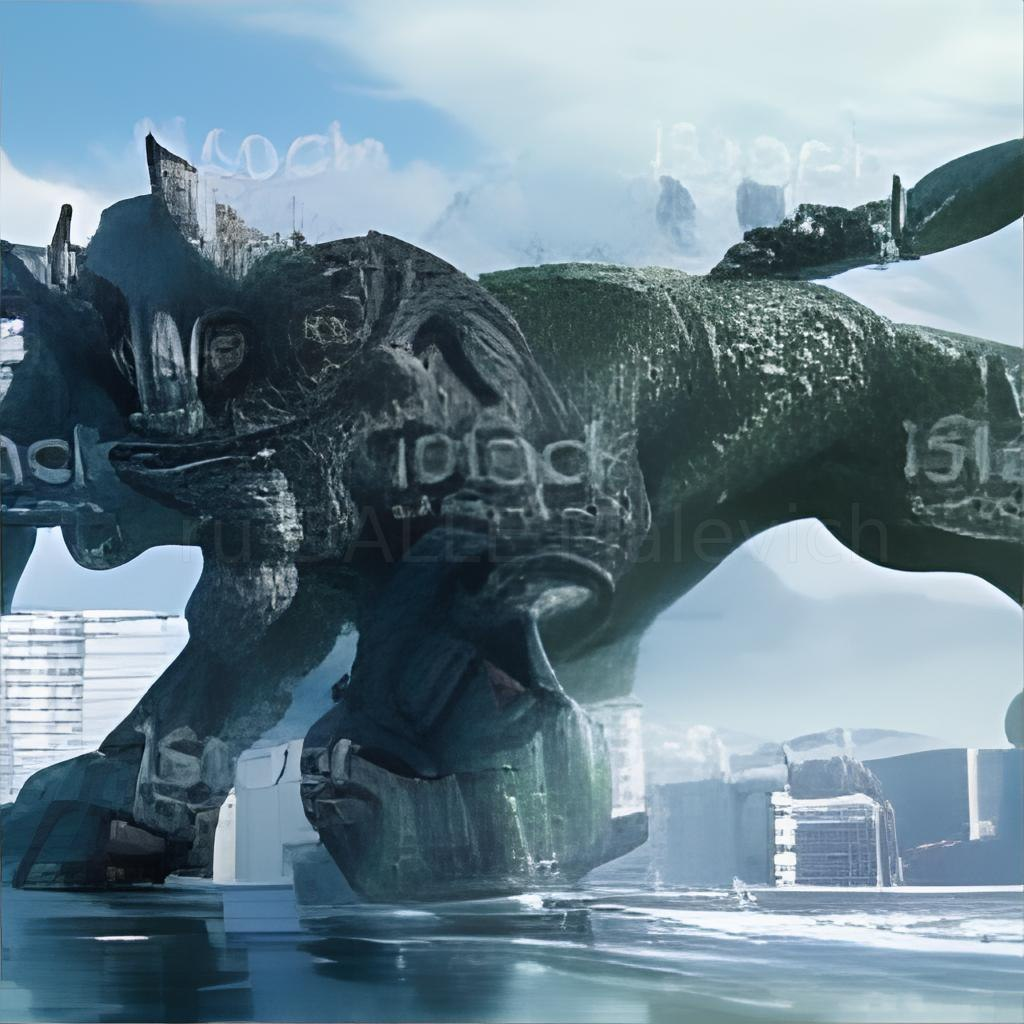

"Нарисуй пейзаж для хайку:

Лучик рассвета

Колаб отобрал ресурс

Упала слеза" 




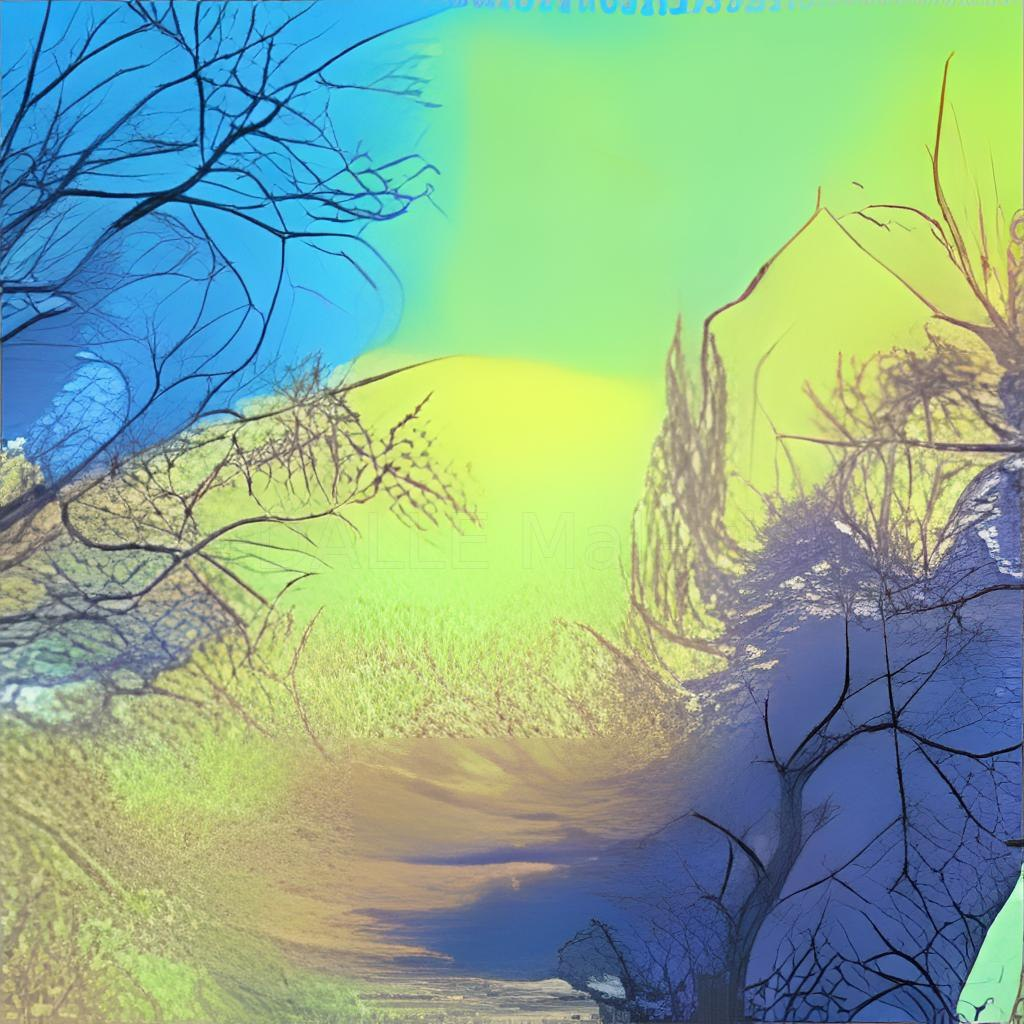

"Ушла эпоха!"

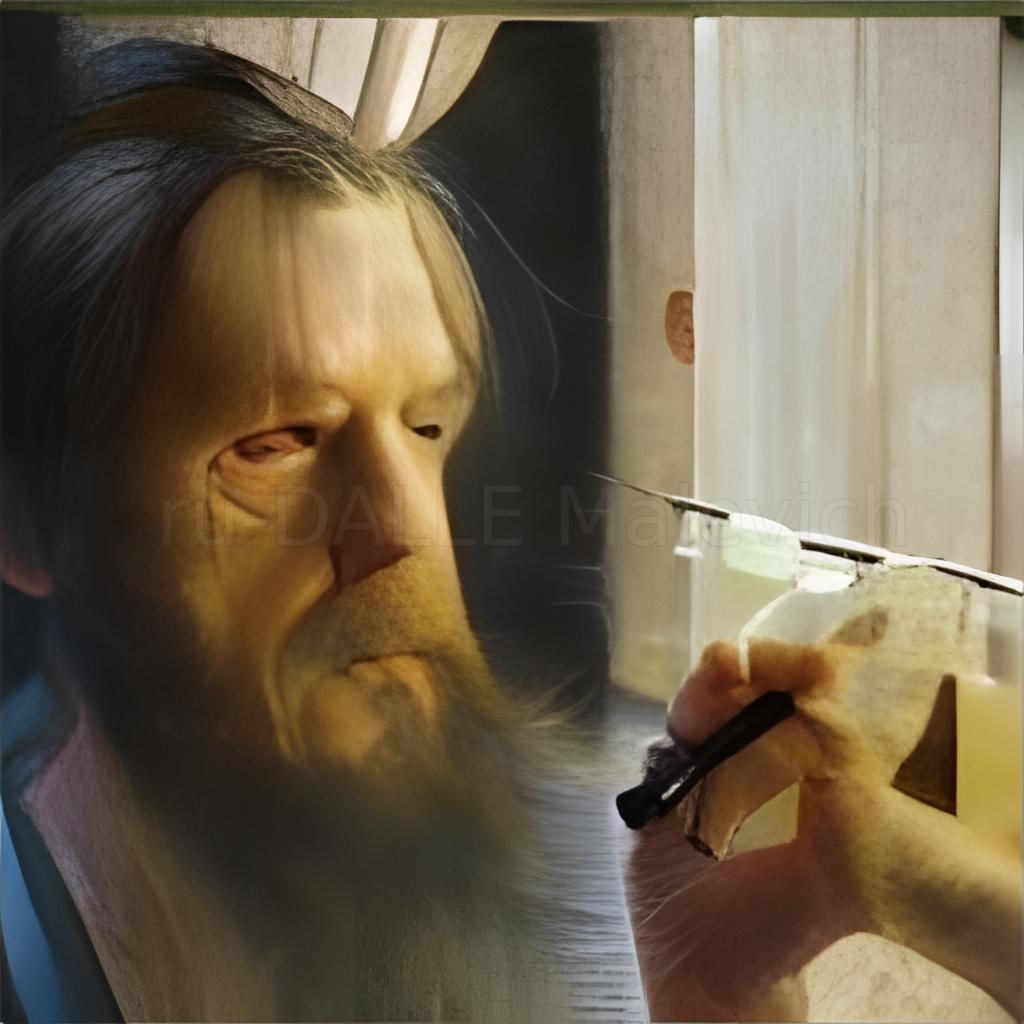